In [8]:
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
import numpy as np
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

file_name = "./bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df = table.to_pandas()




In [9]:
bitcoin_2022_df = df.loc[(df['currency_pair'] == 'BTC_USDT') & (df['year'] == 2022)]

In [10]:
agg_data = bitcoin_2022_df.copy(deep = True)

#strip only time when trying to aggregrate data for mean/median at each 15 min bin (not for intraday)
t = [x.to_pydatetime().strftime("%H:%M:%S") for x in agg_data.index] 

#have to do it this way since agg_data.index.time returns object, 
# so we use datetime however adds dummy date of 1990 thats okay for mean/median calculation
agg_data.index = [datetime.strptime(x, '%H:%M:%S') for x in t]
agg_data.index.name = 'timestamp'

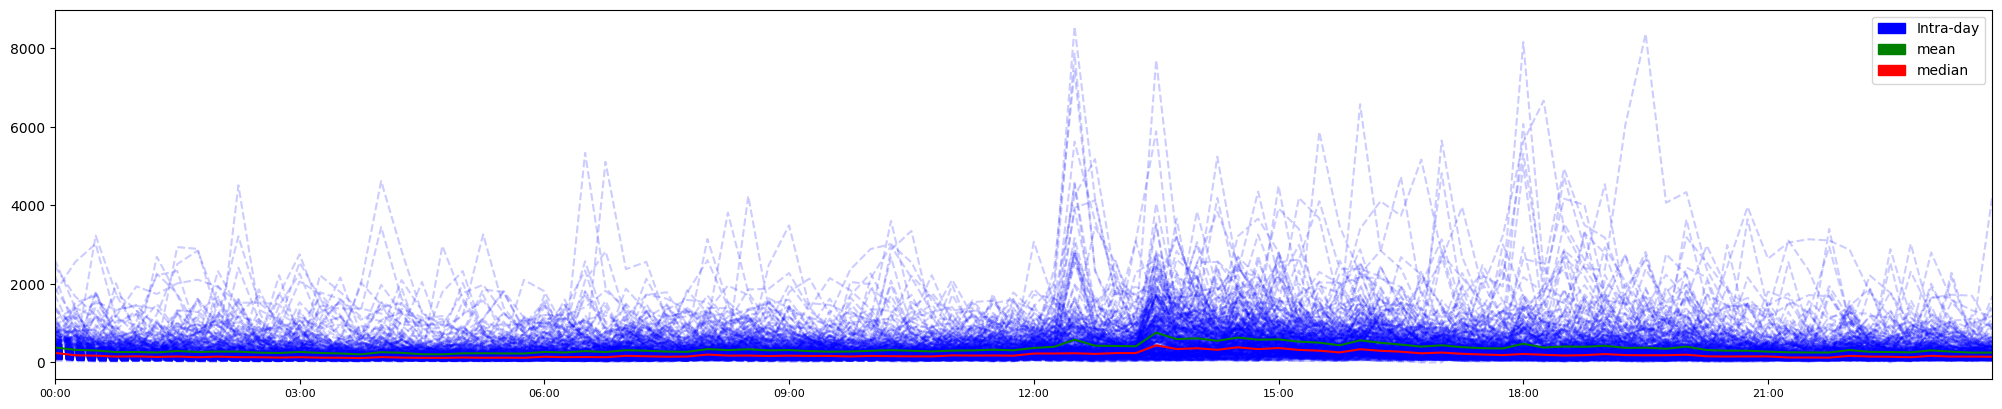

In [11]:
#binning data using pd.Grouper into 15 min bins
temp_sum = bitcoin_2022_df.groupby([pd.Grouper(level = 'timestamp', freq = '15Min')]).mean()
temp_avg = agg_data.groupby([pd.Grouper(level = 'timestamp', freq = '15Min')]).mean()
temp_median = agg_data.groupby([pd.Grouper(level = 'timestamp', freq = '15Min')]).median()

#get each day in temp_sum
unique_days = list(set(temp_sum.index.to_period('D').strftime('%Y-%m-%d')))

time_only = temp_avg.index
fig = plt.figure()
ax = plt.gca()
fig.set_figwidth(25)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for day in unique_days:
    plt.plot(time_only, temp_sum[day].volume, color = 'blue', linestyle = 'dashed', alpha = 0.2)
    

plt.plot(time_only, temp_avg.volume, color = 'green')
plt.plot(time_only, temp_median.volume, color = 'red')  
blue_patch = mpatches.Patch(color='blue', label='Intra-day')
green_patch = mpatches.Patch(color='green', label='mean')
red_patch = mpatches.Patch(color='red', label='median')
ax.legend(handles=[blue_patch, green_patch, red_patch])
plt.xticks(fontsize=8)
ax.margins(x=0) 
    
    



   

    

    